In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
#Configure API key

quandl.ApiConfig.api_key = 'CStdmx_nVPh3vH8tc67e'

In [4]:
#Upload Brazilian Central Bank data for the "National Consumer Price Index (INPC)" variable.

data = quandl.get('BCB/188')

In [5]:
#Check out the newly-uploaded dataset

data.head()

,Value
Date,
1979-04-30,3.45
1979-05-31,1.76
1979-06-30,3.00
1979-07-31,5.36
1979-08-31,5.79


In [6]:
data.shape

(528, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [9]:
type(data)

pandas.core.frame.DataFrame

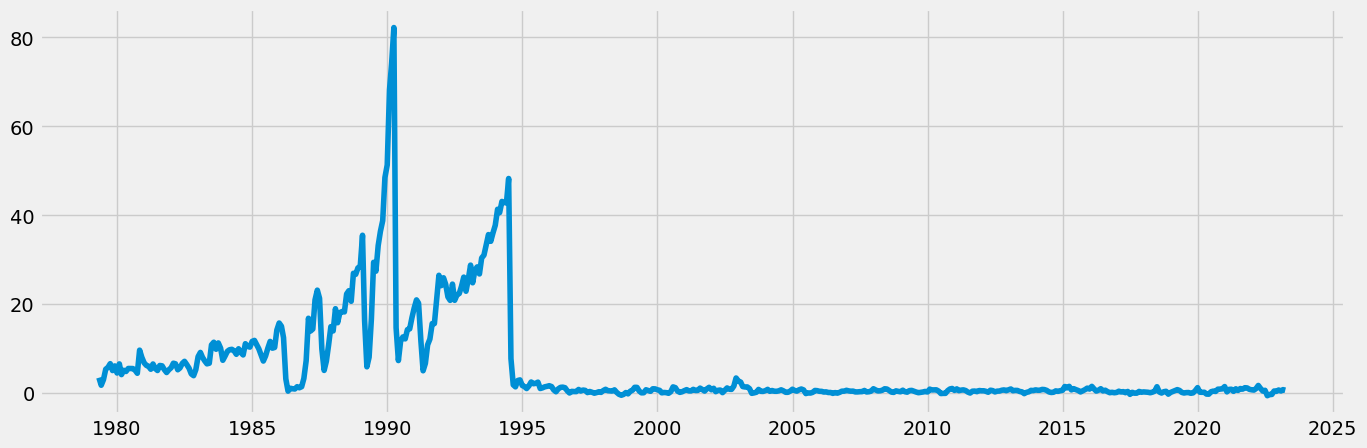

In [10]:
#Plot the data using matplotlib

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

Upon further, outside study, the Brazilian economy underwent massive inflation in the 1980s and early 1990s which culmintated in 
the creation of the Plano Real in 1994 which created the Real de Valor ("real unit of value'). You can clearly that shift in 1994/1995 in the above graph and for that reason, our subset will only include data from the start of 1995 onwards to today, as older economic conditions are not relevant to the situtation today and will only skew the results of our forecast.

(Reference: https://thetranslationcompany.com/resources/language-country/portuguese-language/business-brazil/economy-brazil.htm#:~:text=Through%20the%201980s%20and%201990s,economic%20plans%20that%20were%20unsuccessful.)

### 1.) Subsetting, Wrangling, and Cleaning the Data

In [11]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1979-04-30,3.45
1,1979-05-31,1.76
2,1979-06-30,3.00
3,1979-07-31,5.36
4,1979-08-31,5.79


In [13]:
#Create our subset, leaving out irrelevant data from years prior to 1995.

data_sub = data_2.loc[(data_2['Date'] >= '1995-01-01') & (data_2['Date'] < '2023-03-31')]

In [14]:
data_sub.shape

(338, 2)

In [15]:
data_sub.head()

,Date,Value
189,1995-01-31,1.44
190,1995-02-28,1.01
191,1995-03-31,1.62
192,1995-04-30,2.49
193,1995-05-31,2.10


In [16]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date."
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1995-01-31,1.44
1995-02-28,1.01
1995-03-31,1.62
1995-04-30,2.49
1995-05-31,2.10


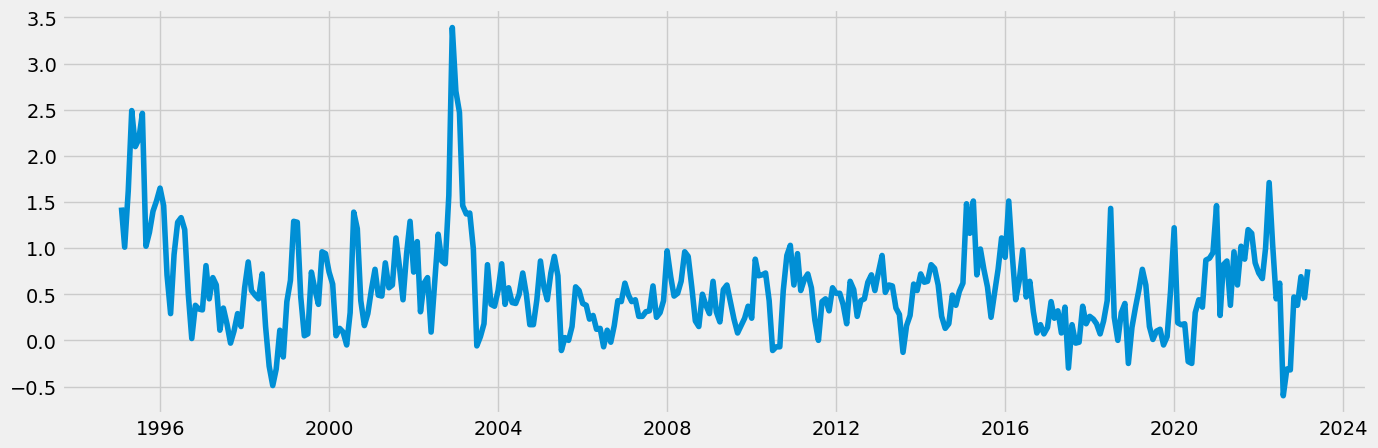

In [17]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [18]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [21]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

#I wouldn't worry about this, as there are only, a max of 2 decimal places so, many months share the same value.

191

### 2.) Time-series analysis: decomposition

In [22]:
#Use an additive model for the decomposition because the big trends of the data are fairly linear and steady-there's not an exponential- or quadratic-style change

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [23]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

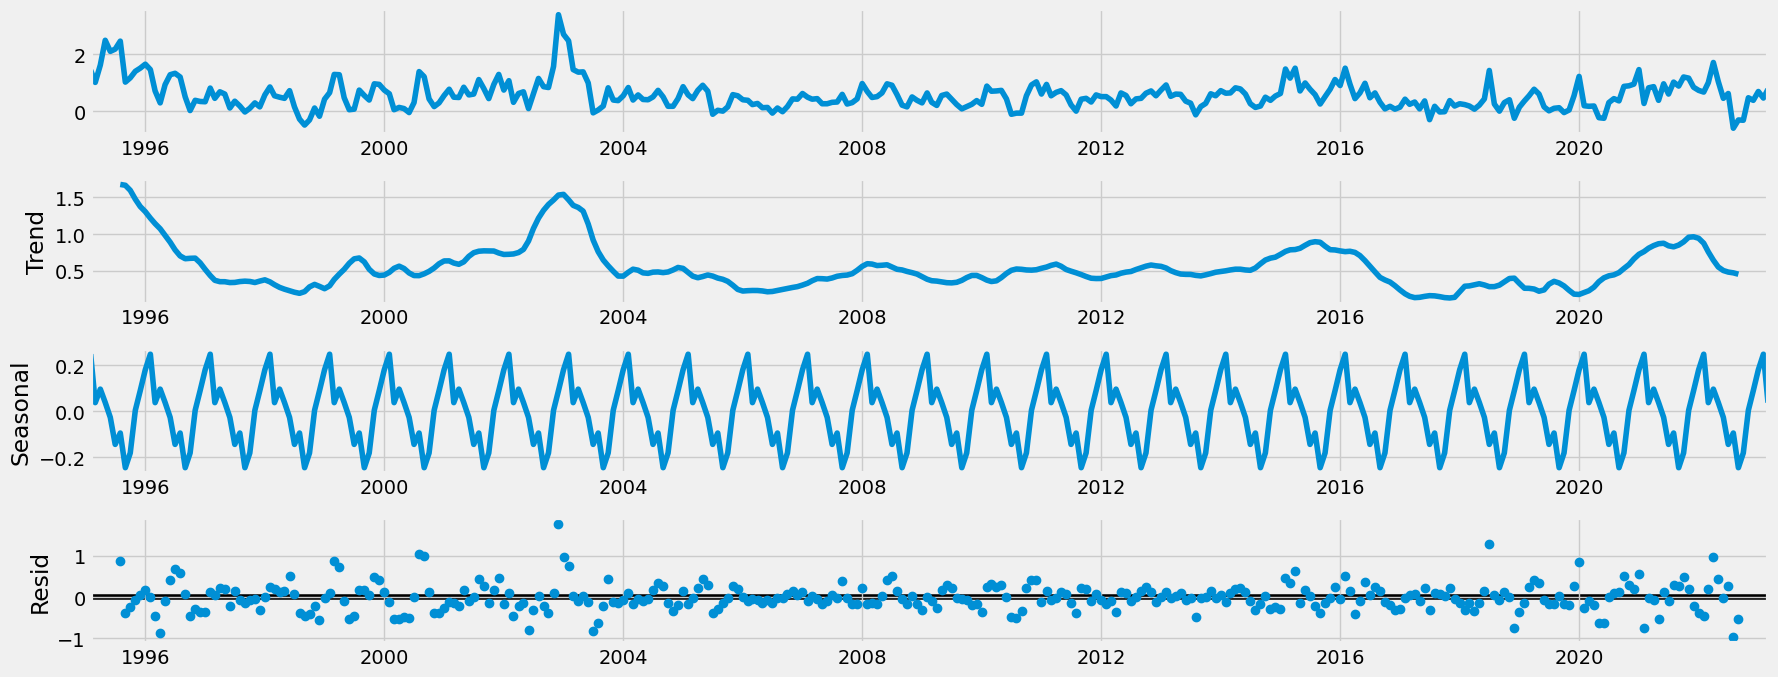

In [24]:
# Plot the separate components of the decomposition

decomposition.plot()
plt.show()

### 3.) Testing for stationarity

In [25]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                -7.684704e+00
p-value                        1.472135e-11
Number of Lags Used            0.000000e+00
Number of Observations Used    3.370000e+02
Critical Value (1%)           -3.449904e+00
Critical Value (5%)           -2.870155e+00
Critical Value (10%)          -2.571360e+00
dtype: float64


The Test Statistic is smaller than the critical values for the 1%, 5%, and 10%. This is a sign that we can reject the null hypothesis (i.e. that we have a unit root, making the data non-stationary and, thus, unsuitable for forecasting.) We may proceed with forecasting.

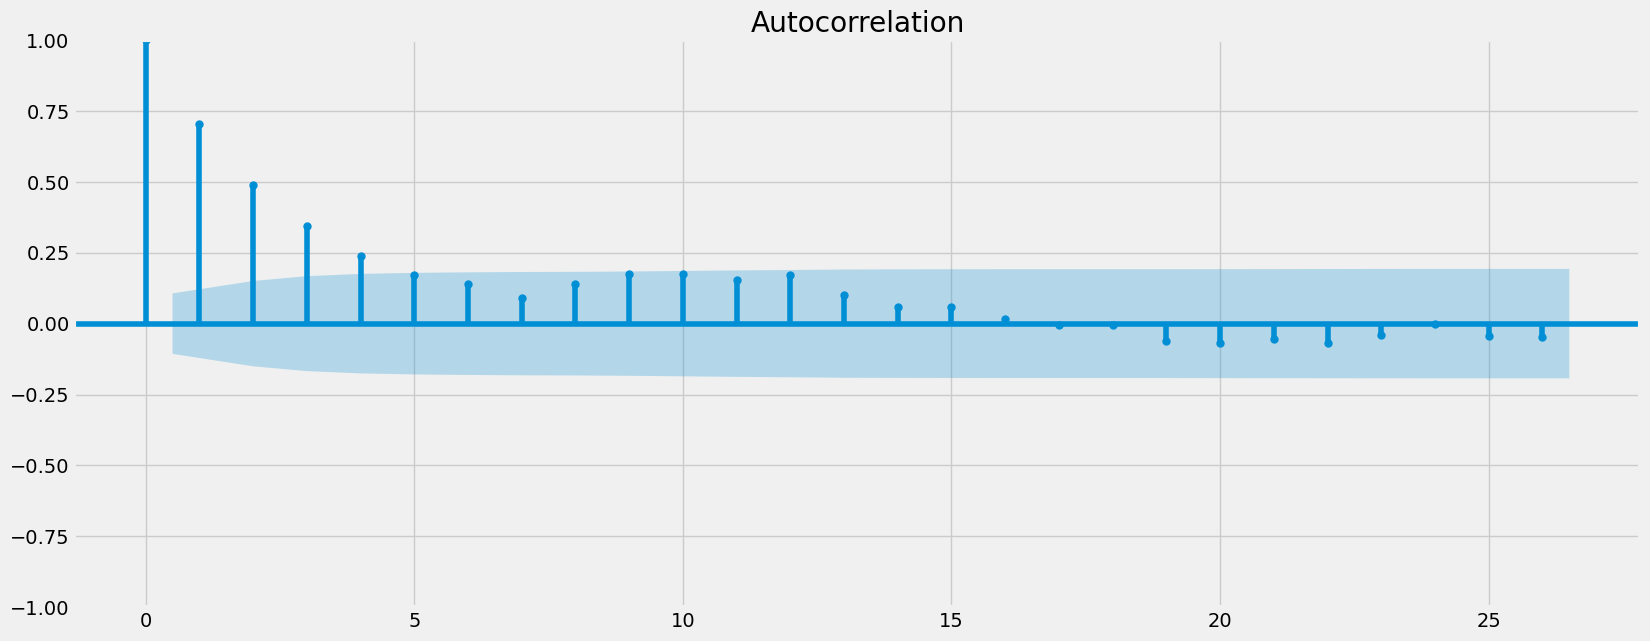

In [27]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()